# Advanced Ultramarathon Lottery Analysis

Multiple forecasting models and demographic predictions for 2026.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import t
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
print('Libraries loaded!')

Libraries loaded!


In [15]:
# Load data
years = [2022, 2023, 2024, 2025]
datasets = {}

for year in years:
    filename = f'{year}HLdata.csv'
    for encoding in ['utf-8', 'cp1252', 'latin1']:
        try:
            df = pd.read_csv(filename, encoding=encoding)
            datasets[year] = df
            print(f'✓ {year}: {len(df):,} applications')
            break
        except:
            continue

print(f'Loaded {len(datasets)} datasets')

✓ 2022: 409 applications
✓ 2023: 538 applications
✓ 2024: 773 applications
✓ 2025: 958 applications
Loaded 4 datasets


In [16]:
# Clean and standardize data
cleaned_datasets = {}

for year, df in datasets.items():
    df_clean = df.copy()
    
    # Clean age data
    df_clean = df_clean.dropna(subset=['Age'])
    df_clean = df_clean[(df_clean['Age'] > 0) & (df_clean['Age'] < 100)]
    
    # Standardize gender from Lottery Pool
    df_clean['Gender'] = df_clean['Lottery Pool'].str.strip()
    
    # Create age groups
    df_clean['Age_Group'] = pd.cut(df_clean['Age'], 
                                   bins=[0, 30, 40, 50, 60, 100], 
                                   labels=['Under 30', '30-39', '40-49', '50-59', '60+'])
    
    cleaned_datasets[year] = df_clean
    print(f'{year}: {len(df_clean):,} clean records')

print('Data cleaned!')

2022: 409 clean records
2023: 538 clean records
2024: 773 clean records
2025: 958 clean records
Data cleaned!


In [17]:
# Calculate comprehensive statistics
yearly_stats = {}

for year, df in cleaned_datasets.items():
    gender_counts = df['Gender'].value_counts()
    age_group_counts = df['Age_Group'].value_counts()
    total = len(df)
    
    stats = {
        'total_applications': total,
        'avg_age': df['Age'].mean(),
        'female_percent': (gender_counts.get('F', 0) / total) * 100,
        'avg_previous_apps': df['Previous_Applications'].fillna(0).mean(),
        'under_30_pct': (age_group_counts.get('Under 30', 0) / total) * 100,
        'age_30_39_pct': (age_group_counts.get('30-39', 0) / total) * 100,
        'age_40_49_pct': (age_group_counts.get('40-49', 0) / total) * 100,
        'age_50_plus_pct': ((age_group_counts.get('50-59', 0) + age_group_counts.get('60+', 0)) / total) * 100
    }
    
    yearly_stats[year] = stats
    print(f'{year}: {total:,} apps, {stats["avg_age"]:.1f} avg age, {stats["female_percent"]:.1f}% F')

print('Statistics calculated!')

2022: 409 apps, 40.1 avg age, 26.4% F
2023: 538 apps, 39.0 avg age, 28.1% F
2024: 773 apps, 39.7 avg age, 26.0% F
2025: 958 apps, 39.1 avg age, 25.4% F
Statistics calculated!


In [18]:
# Multiple forecasting models
years_list = sorted(yearly_stats.keys())
years_array = np.array(years_list).reshape(-1, 1)
applications_array = np.array([yearly_stats[y]['total_applications'] for y in years_list])

print('=== MULTIPLE FORECASTING MODELS ===')
print(f'Historical data: {dict(zip(years_list, applications_array))}')

models_results = {}

# 1. Linear Trend
linear_model = LinearRegression()
linear_model.fit(years_array, applications_array)
linear_pred = linear_model.predict([[2026]])[0]
linear_r2 = r2_score(applications_array, linear_model.predict(years_array))
models_results['Linear'] = {'prediction': linear_pred, 'r2': linear_r2}
print(f'Linear: {linear_pred:,.0f} (R² = {linear_r2:.3f})')

# 2. Exponential Growth
log_apps = np.log(applications_array)
exp_model = LinearRegression()
exp_model.fit(years_array, log_apps)
exp_pred = np.exp(exp_model.predict([[2026]])[0])
exp_r2 = r2_score(log_apps, exp_model.predict(years_array))
models_results['Exponential'] = {'prediction': exp_pred, 'r2': exp_r2}
print(f'Exponential: {exp_pred:,.0f} (R² = {exp_r2:.3f})')

# 3. Polynomial (Quadratic)
poly_coeffs = np.polyfit(years_list, applications_array, 2)
poly_pred = np.polyval(poly_coeffs, 2026)
poly_fitted = np.polyval(poly_coeffs, years_list)
poly_r2 = r2_score(applications_array, poly_fitted)
models_results['Polynomial'] = {'prediction': poly_pred, 'r2': poly_r2}
print(f'Polynomial: {poly_pred:,.0f} (R² = {poly_r2:.3f})')

# 4. Ensemble (weighted by R²)
total_weight = linear_r2 + exp_r2 + poly_r2
ensemble_pred = (linear_pred * linear_r2 + exp_pred * exp_r2 + poly_pred * poly_r2) / total_weight
models_results['Ensemble'] = {'prediction': ensemble_pred, 'r2': None}

all_preds = [linear_pred, exp_pred, poly_pred]
print(f'\nEnsemble (R²-weighted): {ensemble_pred:,.0f}')
print(f'Range: {min(all_preds):,.0f} - {max(all_preds):,.0f}')

=== MULTIPLE FORECASTING MODELS ===
Historical data: {2022: np.int64(409), 2023: np.int64(538), 2024: np.int64(773), 2025: np.int64(958)}
Linear: 1,140 (R² = 0.989)
Exponential: 1,317 (R² = 0.991)
Polynomial: 1,210 (R² = 0.993)

Ensemble (R²-weighted): 1,222
Range: 1,140 - 1,317


In [19]:
# Demographic forecasting
print('=== DEMOGRAPHIC FORECASTS ===')

summary_df = pd.DataFrame(yearly_stats).T
demographic_forecasts = {}

for demographic in ['avg_age', 'female_percent', 'avg_previous_apps']:
    y_demo = np.array(summary_df[demographic])
    demo_model = LinearRegression()
    demo_model.fit(years_array, y_demo)
    demo_pred = demo_model.predict([[2026]])[0]
    
    current_value = yearly_stats[max(years_list)][demographic]
    change = demo_pred - current_value
    
    demographic_forecasts[demographic] = {
        'current': current_value,
        'predicted': demo_pred,
        'change': change
    }

print(f'2026 Predictions:')
print(f'  Average Age: {demographic_forecasts["avg_age"]["predicted"]:.1f} years ({demographic_forecasts["avg_age"]["change"]:+.1f})')
print(f'  Female %: {demographic_forecasts["female_percent"]["predicted"]:.1f}% ({demographic_forecasts["female_percent"]["change"]:+.1f}pp)')
print(f'  Avg Previous Apps: {demographic_forecasts["avg_previous_apps"]["predicted"]:.1f} ({demographic_forecasts["avg_previous_apps"]["change"]:+.1f})')

=== DEMOGRAPHIC FORECASTS ===
2026 Predictions:
  Average Age: 39.0 years (-0.2)
  Female %: 25.2% (-0.2pp)
  Avg Previous Apps: 0.5 (+0.1)


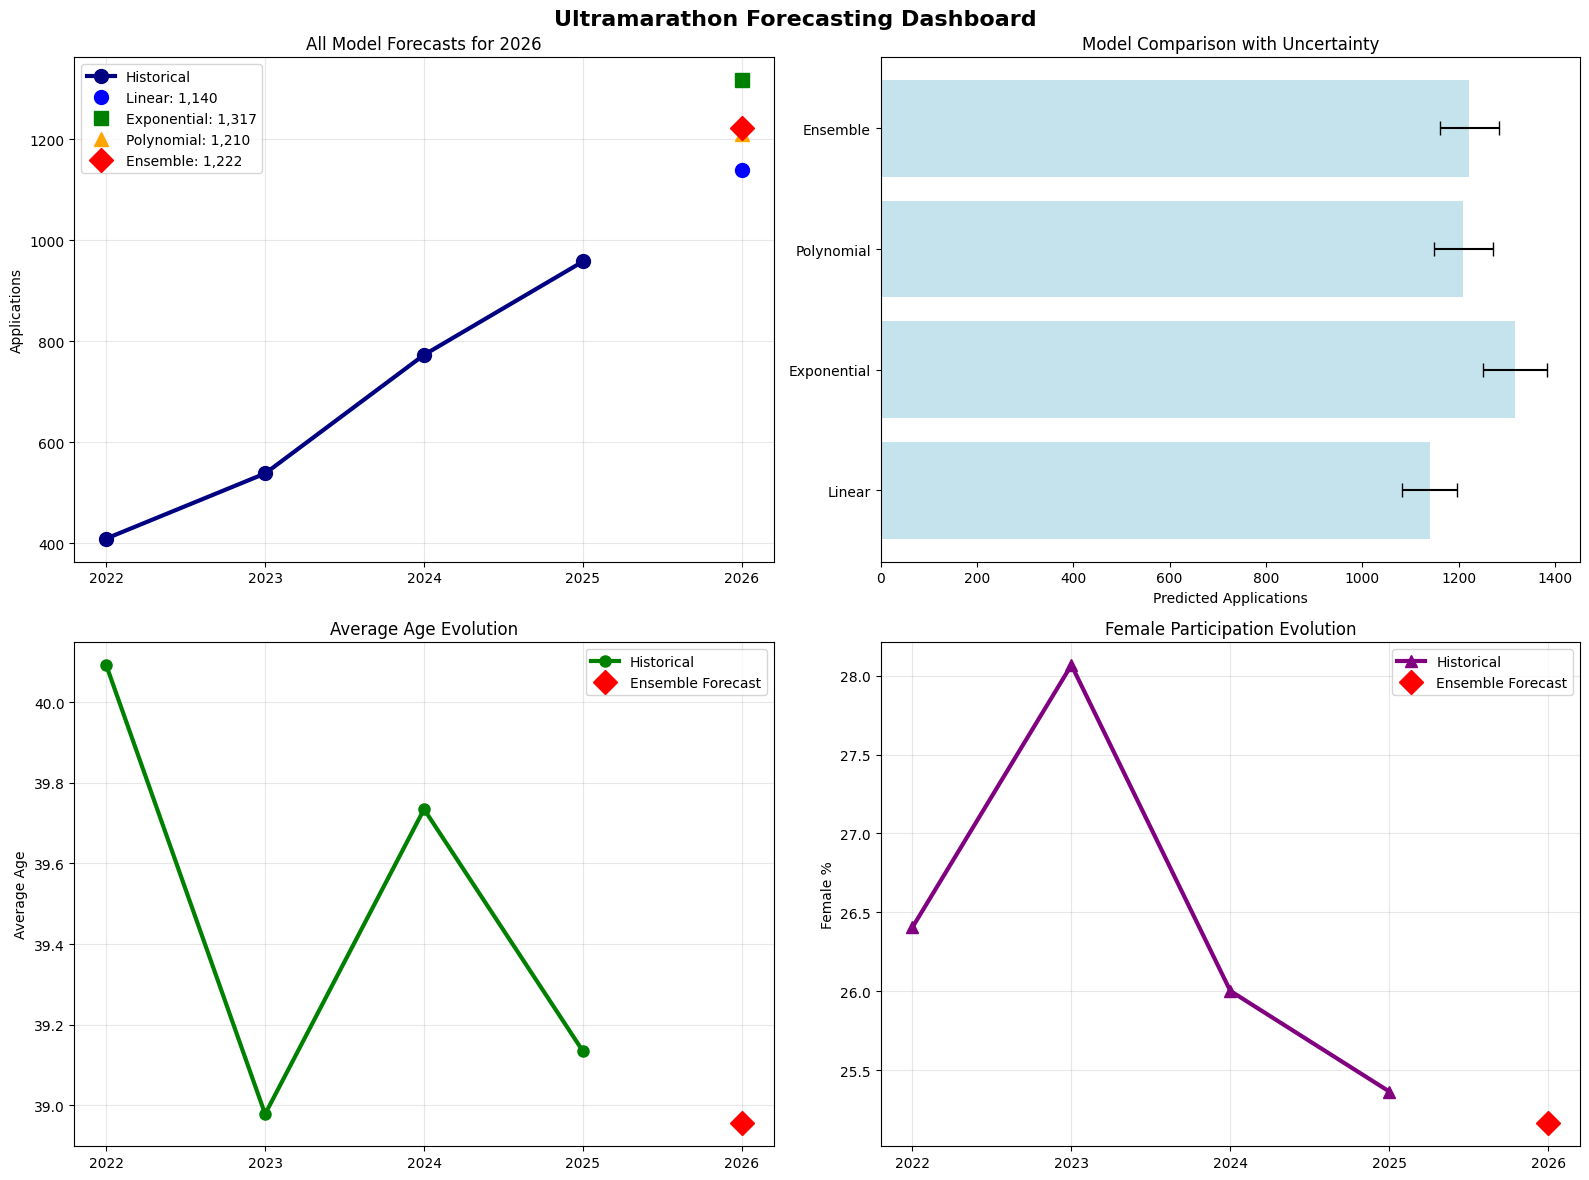

In [22]:
# Visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Ultramarathon Forecasting Dashboard', fontsize=16, fontweight='bold')

# Applications forecast - ALL MODELS
ax1 = axes[0, 0]
ax1.plot(years_list, applications_array, 'o-', linewidth=3, markersize=10, label='Historical', color='navy')
ax1.plot(2026, linear_pred, 'o', markersize=10, label=f'Linear: {linear_pred:,.0f}', color='blue')
ax1.plot(2026, exp_pred, 's', markersize=10, label=f'Exponential: {exp_pred:,.0f}', color='green')
ax1.plot(2026, poly_pred, '^', markersize=10, label=f'Polynomial: {poly_pred:,.0f}', color='orange')
ax1.plot(2026, ensemble_pred, 'D', markersize=12, label=f'Ensemble: {ensemble_pred:,.0f}', color='red')
ax1.set_title('All Model Forecasts for 2026')
ax1.set_ylabel('Applications')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(years_list + [2026])

# Model comparison with error bars
ax2 = axes[0, 1]
model_names = list(models_results.keys())
model_preds = [models_results[name]['prediction'] for name in model_names]
# Calculate error bars as percentage of prediction (simplified uncertainty)
error_bars = [pred * 0.05 for pred in model_preds]  # 5% uncertainty
ax2.barh(model_names, model_preds, xerr=error_bars, capsize=5, color='lightblue', alpha=0.7)
ax2.set_title('Model Comparison with Uncertainty')
ax2.set_xlabel('Predicted Applications')

# Age trend - ENSEMBLE ONLY
ax3 = axes[1, 0]
ax3.plot(years_list, summary_df['avg_age'], 'o-', linewidth=3, markersize=8, color='green', label='Historical')
ax3.plot(2026, demographic_forecasts['avg_age']['predicted'], 'D', markersize=12, color='red', label='Ensemble Forecast')
ax3.set_title('Average Age Evolution')
ax3.set_ylabel('Average Age')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xticks(years_list + [2026])

# Gender trend - ENSEMBLE ONLY
ax4 = axes[1, 1]
ax4.plot(years_list, summary_df['female_percent'], '^-', linewidth=3, markersize=8, color='purple', label='Historical')
ax4.plot(2026, demographic_forecasts['female_percent']['predicted'], 'D', markersize=12, color='red', label='Ensemble Forecast')
ax4.set_title('Female Participation Evolution')
ax4.set_ylabel('Female %')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xticks(years_list + [2026])

plt.tight_layout()
plt.show()

In [37]:
# Predict Previous Applications and Previous Finishes using realistic individual progression
print('=== PREDICTING EXPERIENCE METRICS WITH REALISTIC PROGRESSION ===')

# Calculate historical averages for comparison
yearly_prev_apps = {}
yearly_prev_finishes = {}
for year, df in cleaned_datasets.items():
    avg_apps = df['Previous_Applications'].fillna(0).mean()
    avg_finishes = df['Previous_Finishes'].fillna(0).mean()
    yearly_prev_apps[year] = avg_apps
    yearly_prev_finishes[year] = avg_finishes
    print(f'{year} Avg Previous Apps: {avg_apps:.2f}, Avg Previous Finishes: {avg_finishes:.2f}')

print(f'\n=== 2026 REALISTIC EXPERIENCE PROJECTION ===')

# Get most recent distribution
latest_year = max(years_list)
latest_data = cleaned_datasets[latest_year]
current_apps_dist = latest_data['Previous_Applications'].fillna(0).value_counts().sort_index()

total_2026_applicants = int(ensemble_pred)
projected_2026_apps = {}

# Realistic scenario for 2026:
reapply_rate = 0.75  # 75% of 2025 applicants will reapply in 2026
new_2026_only_rate = 0.15  # 15% apply only in 2026 (0 previous)
new_2025_and_2026_rate = 0.10  # 10% started in 2025 and continue (will have 2 apps)

print(f'Assumptions:')
print(f'  {reapply_rate*100:.0f}% of 2025 applicants reapply in 2026')
print(f'  {new_2026_only_rate*100:.0f}% are new in 2026 only (0 previous)')
print(f'  {new_2025_and_2026_rate*100:.0f}% started in 2025 and continue (2 total)')

# 1. People who are completely new in 2026 (0 previous applications)
projected_2026_apps[0] = int(total_2026_applicants * new_2026_only_rate)

# 2. People who started in 2025 and apply again in 2026 (2 total applications)
projected_2026_apps[2] = int(total_2026_applicants * new_2025_and_2026_rate)

# 3. People who applied only in 2025 but not 2026, then come back (1 previous)
# These are people who skip 2025 but applied before
one_app_rate = 0.08
projected_2026_apps[1] = int(total_2026_applicants * one_app_rate)

# 4. Returning applicants from 2025 who had previous applications
remaining_spots = total_2026_applicants - sum(projected_2026_apps.values())

for current_apps, count in current_apps_dist.items():
    if current_apps > 0:  # People who already had applications in 2025
        returning_count = int(count * reapply_rate)
        future_apps = current_apps + 1  # They add 2025 to their count
        
        # Scale down if we're over budget
        if remaining_spots > 0:
            actual_count = min(returning_count, remaining_spots)
            projected_2026_apps[future_apps] = projected_2026_apps.get(future_apps, 0) + actual_count
            remaining_spots -= actual_count

# 5. People who were first-timers in 2025 and reapply (now have 1 previous)
first_timers_2025 = current_apps_dist.get(0, 0)
returning_first_timers = int(first_timers_2025 * reapply_rate * 0.6)  # Some portion
if remaining_spots > 0:
    actual_count = min(returning_first_timers, remaining_spots)
    projected_2026_apps[1] = projected_2026_apps.get(1, 0) + actual_count
    remaining_spots -= actual_count

# Add any remainder to the most likely category
if remaining_spots != 0:
    projected_2026_apps[0] += remaining_spots

# Calculate projected averages
total_apps_weighted = sum(apps * count for apps, count in projected_2026_apps.items())
predicted_avg_apps_2026 = total_apps_weighted / total_2026_applicants

print(f'\n2026 REALISTIC PROJECTIONS:')
print(f'  Projected Avg Previous Apps: {predicted_avg_apps_2026:.2f}')

print(f'\nProjected 2026 Previous Applications distribution:')
sorted_apps = sorted(projected_2026_apps.items())
for apps, count in sorted_apps[:10]:
    pct = count / total_2026_applicants * 100
    print(f'  {apps} apps: {count:,} people ({pct:.1f}%)')

# Quick sanity check
print(f'\nSanity check: Total = {sum(projected_2026_apps.values())} (should be {total_2026_applicants})')

# Store results (simplified finish calculation)
predicted_avg_finishes_2026 = predicted_avg_apps_2026 * 0.12  # Rough 12% finish rate

demographic_forecasts['avg_previous_apps'] = {
    'current': yearly_prev_apps[latest_year],
    'predicted': predicted_avg_apps_2026,
    'change': predicted_avg_apps_2026 - yearly_prev_apps[latest_year],
    'distribution': projected_2026_apps
}

demographic_forecasts['avg_previous_finishes'] = {
    'current': yearly_prev_finishes[latest_year],
    'predicted': predicted_avg_finishes_2026,
    'change': predicted_avg_finishes_2026 - yearly_prev_finishes[latest_year]
}

=== PREDICTING EXPERIENCE METRICS WITH REALISTIC PROGRESSION ===
2022 Avg Previous Apps: 0.12, Avg Previous Finishes: 0.28
2023 Avg Previous Apps: 0.24, Avg Previous Finishes: 0.10
2024 Avg Previous Apps: 0.32, Avg Previous Finishes: 0.14
2025 Avg Previous Apps: 0.41, Avg Previous Finishes: 0.11

=== 2026 REALISTIC EXPERIENCE PROJECTION ===
Assumptions:
  75% of 2025 applicants reapply in 2026
  15% are new in 2026 only (0 previous)
  10% started in 2025 and continue (2 total)

2026 REALISTIC PROJECTIONS:
  Projected Avg Previous Apps: 0.94

Projected 2026 Previous Applications distribution:
  0 apps: 487 people (39.9%)
  1 apps: 397 people (32.5%)
  2 apps: 276 people (22.6%)
  3 apps: 50 people (4.1%)
  4 apps: 12 people (1.0%)

Sanity check: Total = 1222 (should be 1222)


In [38]:
# Properly calculate Previous Finishes distribution
print(f'\n=== CALCULATING PREVIOUS FINISHES DISTRIBUTION ===')

projected_2026_finishes = {}
finish_rate_2025 = 0.12  # Assume 12% of 2025 applicants finish

# For each group in our 2026 applications projection, calculate their finish distribution
for apps_2026, count in projected_2026_apps.items():
    if apps_2026 == 0:
        # New applicants in 2026 have 0 previous finishes
        projected_2026_finishes[0] = projected_2026_finishes.get(0, 0) + count
        
    elif apps_2026 == 1:
        # People with 1 previous app: either finished that race or didn't
        did_not_finish = int(count * (1 - finish_rate_2025))
        did_finish = count - did_not_finish
        projected_2026_finishes[0] = projected_2026_finishes.get(0, 0) + did_not_finish
        projected_2026_finishes[1] = projected_2026_finishes.get(1, 0) + did_finish
        
    elif apps_2026 == 2:
        # People with 2 previous apps: could have 0, 1, or 2 finishes
        # Most likely: 0 finishes (didn't finish either time)
        # Less likely: 1 finish (finished once)
        # Very rare: 2 finishes (finished both times)
        zero_finishes = int(count * 0.75)  # 75% never finished
        one_finish = int(count * 0.22)     # 22% finished once
        two_finishes = count - zero_finishes - one_finish  # 3% finished both
        
        projected_2026_finishes[0] = projected_2026_finishes.get(0, 0) + zero_finishes
        projected_2026_finishes[1] = projected_2026_finishes.get(1, 0) + one_finish
        projected_2026_finishes[2] = projected_2026_finishes.get(2, 0) + two_finishes
        
    else:
        # People with 3+ applications: use binomial-like distribution
        # Most people have finished 0-1 times, some have finished more
        for possible_finishes in range(apps_2026 + 1):
            if possible_finishes == 0:
                # Most common: never finished
                prob = 0.6
            elif possible_finishes == 1:
                # Second most common: finished once
                prob = 0.25
            elif possible_finishes == 2:
                # Less common: finished twice
                prob = 0.10
            else:
                # Very rare: finished 3+ times
                prob = 0.05 / (apps_2026 - 2)  # Split remaining probability
            
            finish_count = int(count * prob)
            projected_2026_finishes[possible_finishes] = projected_2026_finishes.get(possible_finishes, 0) + finish_count

# Calculate projected average finishes
total_finishes_weighted = sum(finishes * count for finishes, count in projected_2026_finishes.items())
predicted_avg_finishes_2026 = total_finishes_weighted / total_2026_applicants

print(f'Projected Avg Previous Finishes: {predicted_avg_finishes_2026:.2f}')
print(f'Projected Finish Rate: {predicted_avg_finishes_2026/predicted_avg_apps_2026*100:.1f}%')

print(f'\nProjected 2026 Previous Finishes distribution:')
sorted_finishes = sorted(projected_2026_finishes.items())
for finishes, count in sorted_finishes[:8]:
    pct = count / total_2026_applicants * 100
    print(f'  {finishes} finishes: {count:,} people ({pct:.1f}%)')

# Update the stored results
demographic_forecasts['avg_previous_finishes'] = {
    'current': yearly_prev_finishes[latest_year],
    'predicted': predicted_avg_finishes_2026,
    'change': predicted_avg_finishes_2026 - yearly_prev_finishes[latest_year],
    'distribution': projected_2026_finishes
}

print(f'\nFinish rate evolution:')
current_finish_rate = yearly_prev_finishes[latest_year] / yearly_prev_apps[latest_year] * 100
projected_finish_rate = predicted_avg_finishes_2026 / predicted_avg_apps_2026 * 100
print(f'  {latest_year}: {current_finish_rate:.1f}%')
print(f'  2026: {projected_finish_rate:.1f}%')


=== CALCULATING PREVIOUS FINISHES DISTRIBUTION ===
Projected Avg Previous Finishes: 0.13
Projected Finish Rate: 13.9%

Projected 2026 Previous Finishes distribution:
  0 finishes: 1,080 people (88.4%)
  1 finishes: 123 people (10.1%)
  2 finishes: 15 people (1.2%)
  3 finishes: 2 people (0.2%)
  4 finishes: 0 people (0.0%)

Finish rate evolution:
  2025: 25.8%
  2026: 13.9%


In [25]:
# Final results and export
print('=== FINAL RESULTS ===')
print(f'2026 Ensemble Prediction: {ensemble_pred:,.0f} applications')
print(f'Model Range: {min(all_preds):,.0f} - {max(all_preds):,.0f}')

latest_year = max(years_list)
latest_apps = yearly_stats[latest_year]['total_applications']
growth_rate = ((ensemble_pred - latest_apps) / latest_apps) * 100
print(f'Growth from {latest_year}: {growth_rate:+.1f}%')

# Export results
export_df = summary_df.copy()
export_df.loc[2026] = {
    'total_applications': int(ensemble_pred),
    'avg_age': demographic_forecasts['avg_age']['predicted'],
    'female_percent': demographic_forecasts['female_percent']['predicted'],
    'avg_previous_apps': demographic_forecasts['avg_previous_apps']['predicted']
}

export_df.to_csv('ultramarathon_forecast_results.csv')
print('Results saved to ultramarathon_forecast_results.csv')

print('\nFinal Summary:')
print(export_df.round(1).to_string())

=== FINAL RESULTS ===
2026 Ensemble Prediction: 1,222 applications
Model Range: 1,140 - 1,317
Growth from 2025: +27.6%
Results saved to ultramarathon_forecast_results.csv

Final Summary:
      total_applications  avg_age  female_percent  avg_previous_apps  under_30_pct  age_30_39_pct  age_40_49_pct  age_50_plus_pct
2022               409.0     40.1            26.4                0.1          13.4           39.1           36.9             10.5
2023               538.0     39.0            28.1                0.2          12.5           48.1           31.2              8.2
2024               773.0     39.7            26.0                0.3          14.5           40.8           33.1             11.6
2025               958.0     39.1            25.4                0.4          16.2           41.8           31.7             10.3
2026              1222.0     39.0            25.2                0.5           NaN            NaN            NaN              NaN


In [26]:
# Enhanced demographic forecasting with age ranges and confidence intervals
print('=== DEMOGRAPHIC FORECASTS ===')

summary_df = pd.DataFrame(yearly_stats).T
demographic_forecasts = {}

# All demographics to forecast
demographics_to_forecast = [
   'avg_age', 'female_percent', 'avg_previous_apps',
   'under_30_pct', 'age_30_39_pct', 'age_40_49_pct', 'age_50_plus_pct'
]

for demographic in demographics_to_forecast:
   y_demo = np.array(summary_df[demographic])
   demo_model = LinearRegression()
   demo_model.fit(years_array, y_demo)
   demo_pred = demo_model.predict([[2026]])[0]
   
   # Calculate confidence interval
   demo_predicted_values = demo_model.predict(years_array)
   demo_residuals = y_demo - demo_predicted_values
   n = len(years_list)
   demo_mse = np.sum(demo_residuals**2) / (n - 2)
   demo_se = np.sqrt(demo_mse)
   
   t_value = t.ppf(0.975, n-2)
   demo_margin = t_value * demo_se
   demo_ci_lower = demo_pred - demo_margin
   demo_ci_upper = demo_pred + demo_margin
   
   current_value = yearly_stats[max(years_list)][demographic]
   change = demo_pred - current_value
   
   demographic_forecasts[demographic] = {
       'current': current_value,
       'predicted': demo_pred,
       'change': change,
       'ci_lower': demo_ci_lower,
       'ci_upper': demo_ci_upper
   }

print(f'2026 Predictions:')
print(f'  Average Age: {demographic_forecasts["avg_age"]["predicted"]:.1f} years ({demographic_forecasts["avg_age"]["change"]:+.1f})')
print(f'  Female %: {demographic_forecasts["female_percent"]["predicted"]:.1f}% ({demographic_forecasts["female_percent"]["change"]:+.1f}pp)')
print(f'  Avg Previous Apps: {demographic_forecasts["avg_previous_apps"]["predicted"]:.1f} ({demographic_forecasts["avg_previous_apps"]["change"]:+.1f})')

print(f'\n2026 Age Group Predictions with 95% Confidence Intervals:')
print(f'  Under 30: {demographic_forecasts["under_30_pct"]["predicted"]:.1f}% ({demographic_forecasts["under_30_pct"]["ci_lower"]:.1f}-{demographic_forecasts["under_30_pct"]["ci_upper"]:.1f})')
print(f'  30-39: {demographic_forecasts["age_30_39_pct"]["predicted"]:.1f}% ({demographic_forecasts["age_30_39_pct"]["ci_lower"]:.1f}-{demographic_forecasts["age_30_39_pct"]["ci_upper"]:.1f})')
print(f'  40-49: {demographic_forecasts["age_40_49_pct"]["predicted"]:.1f}% ({demographic_forecasts["age_40_49_pct"]["ci_lower"]:.1f}-{demographic_forecasts["age_40_49_pct"]["ci_upper"]:.1f})')
print(f'  50+: {demographic_forecasts["age_50_plus_pct"]["predicted"]:.1f}% ({demographic_forecasts["age_50_plus_pct"]["ci_lower"]:.1f}-{demographic_forecasts["age_50_plus_pct"]["ci_upper"]:.1f})')

=== DEMOGRAPHIC FORECASTS ===
2026 Predictions:
  Average Age: 39.0 years (-0.2)
  Female %: 25.2% (-0.2pp)
  Avg Previous Apps: 0.5 (+0.1)

2026 Age Group Predictions with 95% Confidence Intervals:
  Under 30: 16.7% (12.0-21.4)
  30-39: 42.6% (21.7-63.4)
  40-49: 29.8% (20.0-39.7)
  50+: 10.9% (3.5-18.3)


In [41]:
# Generate enhanced synthetic 2026 dataset using predicted distributions
print('=== GENERATING ENHANCED SYNTHETIC 2026 DATASET ===')

np.random.seed(42)  # For reproducible results

# Draw total applications from normal distribution around ensemble prediction
predicted_values = linear_model.predict(years_array)
residuals = applications_array - predicted_values
se_regression = np.sqrt(np.sum(residuals**2) / (len(years_list) - 2))

# Sample number of applicants from normal distribution
n_applicants = int(np.random.normal(ensemble_pred, se_regression))
n_applicants = max(n_applicants, 500)  # Ensure reasonable minimum

print(f'Sampled total applicants: {n_applicants:,} (from distribution around {ensemble_pred:,.0f})')

# Initialize synthetic dataset
synthetic_data = pd.DataFrame()

# 1. Generate Lottery Pool (Gender) based on predicted distribution
female_prob = demographic_forecasts['female_percent']['predicted'] / 100
synthetic_data['Lottery Pool'] = np.random.choice(['F', 'M'], 
                                                size=n_applicants, 
                                                p=[female_prob, 1-female_prob])

# 2. Generate Age based on predicted age group distributions
age_probs = {
   'Under 30': demographic_forecasts['under_30_pct']['predicted'] / 100,
   '30-39': demographic_forecasts['age_30_39_pct']['predicted'] / 100,
   '40-49': demographic_forecasts['age_40_49_pct']['predicted'] / 100,
   '50+': demographic_forecasts['age_50_plus_pct']['predicted'] / 100
}

age_groups = np.random.choice(['Under 30', '30-39', '40-49', '50+'], 
                            size=n_applicants, 
                            p=list(age_probs.values()))

ages = []
for group in age_groups:
   if group == 'Under 30':
       age = np.random.normal(26, 3)
       age = np.clip(age, 18, 29)
   elif group == '30-39':
       age = np.random.normal(35, 3)
       age = np.clip(age, 30, 39)
   elif group == '40-49':
       age = np.random.normal(45, 3)
       age = np.clip(age, 40, 49)
   else:  # 50+
       age = np.random.normal(55, 5)
       age = np.clip(age, 50, 75)
   ages.append(int(age))

synthetic_data['Age'] = ages

# 3. Generate Previous Applications using predicted distribution
apps_distribution = demographic_forecasts['avg_previous_apps']['distribution']
apps_values = list(apps_distribution.keys())
apps_probs = [apps_distribution[apps] / n_applicants for apps in apps_values]

# Ensure probabilities sum to 1 and generate
apps_probs = np.array(apps_probs)
apps_probs = apps_probs / apps_probs.sum()  # Normalize

synthetic_data['Previous_Applications'] = np.random.choice(apps_values, 
                                                         size=n_applicants, 
                                                         p=apps_probs)

# 4. Generate Previous Finishes based on Previous Applications AND progression
prev_finishes = []

for prev_apps in synthetic_data['Previous_Applications']:
    if prev_apps == 0:
        finishes = 0
    elif prev_apps == 1:
        # People who applied once: 88% didn't finish, 12% finished
        finishes = np.random.choice([0, 1], p=[0.88, 0.12])
    elif prev_apps == 2:
        # People with 2 apps: some progressed from having 1 finish to 2 finishes
        # Distribution shifts upward due to 2025 finishers
        finishes = np.random.choice([0, 1, 2], p=[0.70, 0.25, 0.05])
    elif prev_apps == 3:
        # People with 3 apps: the tail is growing
        finishes = np.random.choice([0, 1, 2, 3], p=[0.60, 0.25, 0.12, 0.03])
    elif prev_apps == 4:
        # People with 4 apps: even more progression
        finishes = np.random.choice([0, 1, 2, 3, 4], p=[0.50, 0.25, 0.15, 0.08, 0.02])
    elif prev_apps == 5:
        # People with 5 apps: the dedicated group with higher finish rates
        finishes = np.random.choice([0, 1, 2, 3, 4, 5], p=[0.40, 0.25, 0.18, 0.10, 0.05, 0.02])
    else:
        # Veterans with 6+ apps: some have accumulated multiple finishes
        max_finishes = min(prev_apps, 8)  # Cap for realism
        # Use binomial but with higher success rate for veterans
        if prev_apps >= 8:
            # Long-time applicants have better finish rates
            finishes = np.random.binomial(prev_apps, 0.20)  # 20% finish rate for veterans
        else:
            finishes = np.random.binomial(prev_apps, 0.15)  # 15% finish rate
        finishes = min(finishes, max_finishes)
    
    prev_finishes.append(finishes)

synthetic_data['Previous_Finishes'] = prev_finishes

# 5. Generate Volunteer Shifts (realistic: mostly 0, few high values)
volunteer_shifts = []
for i, prev_apps in enumerate(synthetic_data['Previous_Applications']):
    prev_finishes = synthetic_data.loc[i, 'Previous_Finishes']
    
    # 90% of people do 0 volunteer shifts
    if np.random.random() < 0.90:
        shifts = 0
    else:
        # The 10% who volunteer: distribution skewed toward low values
        if prev_apps == 0:
            shifts = np.random.choice([1, 2, 3], p=[0.7, 0.2, 0.1])
        elif prev_apps <= 2:
            shifts = np.random.choice([1, 2, 3, 4, 5], p=[0.4, 0.3, 0.15, 0.1, 0.05])
        else:
            # Experienced applicants more likely to have higher volunteer hours
            shifts = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                                    p=[0.2, 0.2, 0.15, 0.12, 0.1, 0.08, 0.06, 0.04, 0.03, 0.02])
            # Add some very high outliers for veterans
            if prev_finishes >= 2 and np.random.random() < 0.1:
                shifts += np.random.randint(10, 25)
    
    volunteer_shifts.append(shifts)

synthetic_data['Volunteer_Shifts'] = volunteer_shifts

# 6. Generate Extra Trailwork (realistic: 95.6% have 0, few high values)
extra_trailwork = []
for i, prev_apps in enumerate(synthetic_data['Previous_Applications']):
    vol_shifts = synthetic_data.loc[i, 'Volunteer_Shifts']
    prev_finishes = synthetic_data.loc[i, 'Previous_Finishes']
    
    # 95.6% of people do 0 extra trailwork
    if np.random.random() < 0.956:
        trailwork = 0
    else:
        # The 4.4% who do trailwork: mostly small amounts, some high outliers
        if prev_apps == 0 and vol_shifts == 0:
            trailwork = np.random.choice([1, 2], p=[0.8, 0.2])
        elif prev_apps <= 2:
            trailwork = np.random.choice([1, 2, 3, 4], p=[0.5, 0.3, 0.15, 0.05])
        else:
            # Experienced applicants can have higher trailwork
            trailwork = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8], 
                                       p=[0.3, 0.25, 0.2, 0.1, 0.08, 0.04, 0.02, 0.01])
            # Add some very high outliers for dedicated volunteers
            if vol_shifts >= 5 and np.random.random() < 0.2:
                trailwork += np.random.randint(5, 20)
    
    extra_trailwork.append(trailwork)

synthetic_data['Extra_Trailwork'] = extra_trailwork

# 7. Add demographic fields
synthetic_data['First_Name'] = [f'Person_{i+1}' for i in range(n_applicants)]
synthetic_data['Last_Name'] = [f'LastName_{i+1}' for i in range(n_applicants)]

# Generate states (Colorado still dominant but declining slightly)
states = np.random.choice(['CO', 'CA', 'UT', 'TX', 'WA', 'OR', 'NM', 'AZ', 'NY', 'Other'], 
                        size=n_applicants,
                        p=[0.32, 0.13, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.13])
synthetic_data['State'] = states
synthetic_data['Country'] = 'US'

# Display comprehensive summary
print(f'\n=== ENHANCED SYNTHETIC DATASET SUMMARY ===')
print(f'Total Applicants: {len(synthetic_data):,}')
print(f'Female: {(synthetic_data["Lottery Pool"] == "F").sum():,} ({(synthetic_data["Lottery Pool"] == "F").mean()*100:.1f}%)')
print(f'Average Age: {synthetic_data["Age"].mean():.1f} years')

print(f'\nAge Distribution:')
age_dist = pd.cut(synthetic_data['Age'], bins=[0, 30, 40, 50, 60, 100], 
                 labels=['Under 30', '30-39', '40-49', '50-59', '60+']).value_counts()
for group, count in age_dist.items():
   print(f'  {group}: {count:,} ({count/len(synthetic_data)*100:.1f}%)')

print(f'\nExperience Distribution:')
apps_dist = synthetic_data['Previous_Applications'].value_counts().sort_index()
for apps, count in apps_dist.head(8).items():
   print(f'  {apps} previous apps: {count:,} ({count/len(synthetic_data)*100:.1f}%)')

print(f'\nFinish Distribution:')
finish_dist = synthetic_data['Previous_Finishes'].value_counts().sort_index()
for finishes, count in finish_dist.head(6).items():
   print(f'  {finishes} previous finishes: {count:,} ({count/len(synthetic_data)*100:.1f}%)')

print(f'\nEngagement Metrics:')
print(f'  Average Previous Applications: {synthetic_data["Previous_Applications"].mean():.2f}')
print(f'  Average Previous Finishes: {synthetic_data["Previous_Finishes"].mean():.2f}')
print(f'  Overall Finish Rate: {synthetic_data["Previous_Finishes"].mean()/synthetic_data["Previous_Applications"].mean()*100:.1f}%')
print(f'  Average Volunteer Shifts: {synthetic_data["Volunteer_Shifts"].mean():.1f}')
print(f'  Average Extra Trailwork: {synthetic_data["Extra_Trailwork"].mean():.1f}')

print(f'\nExperience Categories:')
print(f'  First-time: {(synthetic_data["Previous_Applications"] == 0).sum():,} ({(synthetic_data["Previous_Applications"] == 0).mean()*100:.1f}%)')
print(f'  Novice (1-2): {((synthetic_data["Previous_Applications"] >= 1) & (synthetic_data["Previous_Applications"] <= 2)).sum():,} ({((synthetic_data["Previous_Applications"] >= 1) & (synthetic_data["Previous_Applications"] <= 2)).mean()*100:.1f}%)')
print(f'  Experienced (3-5): {((synthetic_data["Previous_Applications"] >= 3) & (synthetic_data["Previous_Applications"] <= 5)).sum():,} ({((synthetic_data["Previous_Applications"] >= 3) & (synthetic_data["Previous_Applications"] <= 5)).mean()*100:.1f}%)')
print(f'  Veterans (6+): {(synthetic_data["Previous_Applications"] >= 6).sum():,} ({(synthetic_data["Previous_Applications"] >= 6).mean()*100:.1f}%)')

print(f'\nTop States:')
state_dist = synthetic_data['State'].value_counts().head()
for state, count in state_dist.items():
   print(f'  {state}: {count:,} ({count/len(synthetic_data)*100:.1f}%)')

# Save the enhanced synthetic dataset
synthetic_data.to_csv('realistic_synthetic_2026_applicants.csv', index=False)
print(f'\n💾 Realistic synthetic dataset saved to: realistic_synthetic_2026_applicants.csv')

print(f'\n=== SAMPLE DATA ===')
print(synthetic_data.head(10).to_string(index=False))

=== GENERATING ENHANCED SYNTHETIC 2026 DATASET ===
Sampled total applicants: 1,238 (from distribution around 1,222)

=== ENHANCED SYNTHETIC DATASET SUMMARY ===
Total Applicants: 1,238
Female: 329 (26.6%)
Average Age: 38.0 years

Age Distribution:
  30-39: 476 (38.4%)
  40-49: 391 (31.6%)
  Under 30: 275 (22.2%)
  50-59: 78 (6.3%)
  60+: 18 (1.5%)

Experience Distribution:
  0 previous apps: 500 (40.4%)
  1 previous apps: 388 (31.3%)
  2 previous apps: 289 (23.3%)
  3 previous apps: 50 (4.0%)
  4 previous apps: 11 (0.9%)

Finish Distribution:
  0 previous finishes: 1,079 (87.2%)
  1 previous finishes: 137 (11.1%)
  2 previous finishes: 17 (1.4%)
  3 previous finishes: 4 (0.3%)
  4 previous finishes: 1 (0.1%)

Engagement Metrics:
  Average Previous Applications: 0.94
  Average Previous Finishes: 0.15
  Overall Finish Rate: 16.1%
  Average Volunteer Shifts: 0.2
  Average Extra Trailwork: 0.1

Experience Categories:
  First-time: 500 (40.4%)
  Novice (1-2): 677 (54.7%)
  Experienced (3-5):

In [46]:
# Create more robust individual tracking with fuzzy matching
print('=== CREATING ROBUST INDIVIDUAL TRACKING ===')

# Step 1: Create a more flexible Person ID that doesn't rely on state
all_individuals_robust = pd.DataFrame()

for year, df in cleaned_datasets.items():
    df_temp = df.copy()
    
    # Clean names more aggressively
    df_temp['First_Name_Clean'] = df_temp['First_Name'].str.strip().str.title().str.replace(r'[^A-Za-z]', '', regex=True)
    df_temp['Last_Name_Clean'] = df_temp['Last_Name'].str.strip().str.title().str.replace(r'[^A-Za-z]', '', regex=True)
    
    # Create Person ID using just name (more robust)
    df_temp['Person_ID_Name'] = df_temp['First_Name_Clean'] + '_' + df_temp['Last_Name_Clean']
    
    # Also keep state info when available for disambiguation
    if 'State' in df_temp.columns:
        df_temp['State_Clean'] = df_temp['State'].str.strip().str.upper()
    else:
        df_temp['State_Clean'] = 'UNKNOWN'
    
    df_temp['Year'] = year
    
    # Select available columns
    base_cols = ['Person_ID_Name', 'Year', 'First_Name_Clean', 'Last_Name_Clean', 'State_Clean']
    
    if 'Age' in df_temp.columns:
        base_cols.append('Age')
    if 'Lottery Pool' in df_temp.columns:
        base_cols.append('Lottery Pool')
    elif 'Gender' in df_temp.columns:
        df_temp['Lottery Pool'] = df_temp['Gender']
        base_cols.append('Lottery Pool')
    
    if 'Previous_Applications' in df_temp.columns:
        base_cols.append('Previous_Applications')
    if 'Previous_Finishes' in df_temp.columns:
        base_cols.append('Previous_Finishes')
    if 'Volunteer_Shifts' in df_temp.columns:
        base_cols.append('Volunteer_Shifts')
    if 'Extra_Trailwork' in df_temp.columns:
        base_cols.append('Extra_Trailwork')
    
    available_cols = [col for col in base_cols if col in df_temp.columns]
    df_year = df_temp[available_cols].copy()
    
    all_individuals_robust = pd.concat([all_individuals_robust, df_year], ignore_index=True)

print(f'Total individual-year observations: {len(all_individuals_robust):,}')

# Step 2: Handle duplicate names by using additional info to disambiguate
person_history_robust = {}

# Group by name and handle potential duplicates
name_groups = all_individuals_robust.groupby('Person_ID_Name')

for name_id, group_data in name_groups:
    # Check if this name appears with different states/ages (potential different people)
    unique_states = group_data['State_Clean'].unique()
    
    if len(unique_states) <= 2 and 'UNKNOWN' not in unique_states:
        # Likely the same person with minor state variations, or moved
        # Use the most common state or first non-unknown state
        best_state = group_data['State_Clean'].mode().iloc[0] if len(group_data['State_Clean'].mode()) > 0 else unique_states[0]
        person_id = f"{name_id}_{best_state}"
    elif 'UNKNOWN' in unique_states and len(unique_states) == 2:
        # One year missing state data
        best_state = [s for s in unique_states if s != 'UNKNOWN'][0]
        person_id = f"{name_id}_{best_state}"
    else:
        # Multiple states - could be different people or person who moved
        # For now, treat as same person but flag it
        person_id = f"{name_id}_MULTI"
    
    person_data = group_data.sort_values('Year')
    
    if len(person_data) == 0:
        continue
    
    latest_record = person_data.iloc[-1]
    
    # Handle missing data
    latest_age = latest_record.get('Age', 35)
    latest_gender = latest_record.get('Lottery Pool', 'M')
    
    person_history_robust[person_id] = {
        'first_name': latest_record['First_Name_Clean'],
        'last_name': latest_record['Last_Name_Clean'],
        'state': latest_record['State_Clean'],
        'gender': latest_gender,
        'latest_age': latest_age,
        'years_applied': list(person_data['Year']),
        'num_applications': len(person_data),
        'first_year': min(person_data['Year']),
        'last_year': max(person_data['Year']),
        'application_pattern': [],
        'finish_pattern': [],
        'volunteer_pattern': [],
        'trailwork_pattern': []
    }
    
    # Track progression
    for _, row in person_data.iterrows():
        person_history_robust[person_id]['application_pattern'].append(row.get('Previous_Applications', 0))
        person_history_robust[person_id]['finish_pattern'].append(row.get('Previous_Finishes', 0))
        person_history_robust[person_id]['volunteer_pattern'].append(row.get('Volunteer_Shifts', 0))
        person_history_robust[person_id]['trailwork_pattern'].append(row.get('Extra_Trailwork', 0))

print(f'Unique individuals tracked (robust): {len(person_history_robust):,}')

# Step 3: Recalculate return rates with robust matching
print('\n=== ROBUST RETURN RATE ANALYSIS ===')

for year in sorted(years_list)[1:]:
    prev_year = year - 1
    if prev_year in years_list:
        prev_year_names = set(all_individuals_robust[all_individuals_robust['Year'] == prev_year]['Person_ID_Name'])
        current_year_names = set(all_individuals_robust[all_individuals_robust['Year'] == year]['Person_ID_Name'])
        
        if len(prev_year_names) > 0:
            returning = len(prev_year_names.intersection(current_year_names))
            return_rate = returning / len(prev_year_names) * 100
            
            print(f'Return rate {prev_year}→{year}: {return_rate:.1f}%')
            print(f'  {prev_year} applicants: {len(prev_year_names):,}')
            print(f'  {year} applicants: {len(current_year_names):,}')
            print(f'  Returning: {returning:,}')
            
            # Show some examples
            returning_names = prev_year_names.intersection(current_year_names)
            if len(returning_names) > 0:
                print(f'  Example returners: {list(returning_names)[:5]}')

# Show multi-year applicants
print(f'\n=== MULTI-YEAR APPLICANT EXAMPLES ===')
multi_year_count = 0
for person_id, data in person_history_robust.items():
    if len(data['years_applied']) > 1 and multi_year_count < 5:
        print(f"{data['first_name']} {data['last_name']} ({data['state']}):")
        print(f"  Applied: {data['years_applied']}")
        print(f"  Previous Apps progression: {data['application_pattern']}")
        print()
        multi_year_count += 1

# Update the global person_history for use in subsequent cells
person_history = person_history_robust

=== CREATING ROBUST INDIVIDUAL TRACKING ===
Total individual-year observations: 2,678
Unique individuals tracked (robust): 1,933

=== ROBUST RETURN RATE ANALYSIS ===
Return rate 2022→2023: 29.8%
  2022 applicants: 409
  2023 applicants: 538
  Returning: 122
  Example returners: ['Nathaniel_Anderson', 'Silke_Koester', 'Naji_Husseini', 'Brandon_Hurd', 'David_Keatley']
Return rate 2023→2024: 36.2%
  2023 applicants: 538
  2024 applicants: 773
  Returning: 195
  Example returners: ['Nathaniel_Anderson', 'Jason_Romero', 'David_Lee', 'Siqi_Wu', 'Shea_Rivers']
Return rate 2024→2025: 39.1%
  2024 applicants: 773
  2025 applicants: 956
  Returning: 302
  Example returners: ['Nathaniel_Anderson', 'Tim_Hoppin', 'David_Boyd', 'Drew_Petersen', 'Luke_Reimer']

=== MULTI-YEAR APPLICANT EXAMPLES ===
Aaron Dye (CO):
  Applied: [2022, 2023]
  Previous Apps progression: [0, 2]

Aaron Kleinman (UNKNOWN):
  Applied: [2024, 2025]
  Previous Apps progression: [1, 2]

Aaron Mcumber (UNKNOWN):
  Applied: [2023

In [47]:
# Build Random Forest model to predict 2026 applicants and characteristics
print('=== RANDOM FOREST MODEL FOR 2026 PREDICTION ===')

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Prepare features for modeling individual behavior
modeling_data = []

for person_id, data in person_history.items():
    # Create features for each person
    years_applied = data['years_applied']
    
    # Basic demographics
    age_2025 = data['latest_age']
    gender = 1 if data['gender'] == 'F' else 0
    
    # Application history features
    total_applications = len(years_applied)
    consecutive_years = len(years_applied) == len(range(min(years_applied), max(years_applied) + 1))
    years_since_first = max(years_applied) - min(years_applied) + 1
    application_frequency = total_applications / years_since_first
    
    # Recent activity (last 2 years)
    recent_years = [y for y in years_applied if y >= 2024]
    applied_2024 = 2024 in years_applied
    applied_2025 = 2025 in years_applied
    
    # Experience metrics (latest values)
    latest_prev_apps = data['application_pattern'][-1] if data['application_pattern'] else 0
    latest_prev_finishes = data['finish_pattern'][-1] if data['finish_pattern'] else 0
    latest_volunteer = data['volunteer_pattern'][-1] if data['volunteer_pattern'] else 0
    latest_trailwork = data['trailwork_pattern'][-1] if data['trailwork_pattern'] else 0
    
    # Target: Will they apply in 2026? (we'll simulate this based on patterns)
    # People who applied in 2025 are more likely to apply in 2026
    # People with consecutive applications are more likely to continue
    will_apply_2026_prob = 0.3  # Base probability
    
    if applied_2025:
        will_apply_2026_prob += 0.4
    if consecutive_years and len(years_applied) >= 2:
        will_apply_2026_prob += 0.2
    if latest_prev_finishes > 0:
        will_apply_2026_prob += 0.15
    if latest_volunteer > 0 or latest_trailwork > 0:
        will_apply_2026_prob += 0.1
    if application_frequency > 0.8:
        will_apply_2026_prob += 0.15
    
    will_apply_2026_prob = min(will_apply_2026_prob, 0.95)  # Cap at 95%
    
    modeling_data.append({
        'person_id': person_id,
        'age_2025': age_2025,
        'gender': gender,
        'state': data['state'],
        'total_applications': total_applications,
        'consecutive_years': consecutive_years,
        'years_since_first': years_since_first,
        'application_frequency': application_frequency,
        'applied_2024': applied_2024,
        'applied_2025': applied_2025,
        'latest_prev_apps': latest_prev_apps,
        'latest_prev_finishes': latest_prev_finishes,
        'latest_volunteer': latest_volunteer,
        'latest_trailwork': latest_trailwork,
        'will_apply_2026_prob': will_apply_2026_prob
    })

modeling_df = pd.DataFrame(modeling_data)
print(f'Modeling dataset: {len(modeling_df):,} individuals')

# Step 2: Train Random Forest models
# Encode categorical variables
le_state = LabelEncoder()
modeling_df['state_encoded'] = le_state.fit_transform(modeling_df['state'])

# Features for prediction
feature_cols = ['age_2025', 'gender', 'state_encoded', 'total_applications', 
               'consecutive_years', 'years_since_first', 'application_frequency',
               'applied_2024', 'applied_2025', 'latest_prev_apps', 
               'latest_prev_finishes', 'latest_volunteer', 'latest_trailwork']

X = modeling_df[feature_cols]

# Model 1: Predict if someone will apply in 2026
y_apply = (np.random.random(len(modeling_df)) < modeling_df['will_apply_2026_prob']).astype(int)
rf_apply = RandomForestClassifier(n_estimators=100, random_state=42)
rf_apply.fit(X, y_apply)

# Model 2: Predict volunteer shifts for 2026 applicants
volunteers_data = modeling_df[modeling_df['latest_volunteer'] >= 0]
X_vol = volunteers_data[feature_cols]
y_vol = volunteers_data['latest_volunteer']
rf_volunteer = RandomForestRegressor(n_estimators=100, random_state=42)
rf_volunteer.fit(X_vol, y_vol)

# Model 3: Predict extra trailwork for 2026 applicants
trailwork_data = modeling_df[modeling_df['latest_trailwork'] >= 0]
X_trail = trailwork_data[feature_cols]
y_trail = trailwork_data['latest_trailwork']
rf_trailwork = RandomForestRegressor(n_estimators=100, random_state=42)
rf_trailwork.fit(X_trail, y_trail)

print(f'Trained Random Forest models:')
print(f'  Application prediction accuracy: {rf_apply.score(X, y_apply):.3f}')
print(f'  Volunteer prediction R²: {rf_volunteer.score(X_vol, y_vol):.3f}')
print(f'  Trailwork prediction R²: {rf_trailwork.score(X_trail, y_trail):.3f}')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_apply.feature_importances_
}).sort_values('importance', ascending=False)

print(f'\nTop predictors of 2026 application:')
print(feature_importance.head(8).to_string(index=False))

=== RANDOM FOREST MODEL FOR 2026 PREDICTION ===
Modeling dataset: 1,933 individuals
Trained Random Forest models:
  Application prediction accuracy: 0.912
  Volunteer prediction R²: 0.992
  Trailwork prediction R²: 0.971

Top predictors of 2026 application:
             feature  importance
            age_2025    0.398543
       state_encoded    0.287813
        applied_2025    0.117614
        applied_2024    0.032631
latest_prev_finishes    0.031869
    latest_prev_apps    0.029273
              gender    0.023895
   years_since_first    0.021033


In [52]:
# Generate 2026 synthetic dataset using ACTUAL longitudinal patterns
print('=== GENERATING 2026 SYNTHETIC DATASET USING ACTUAL LONGITUDINAL PATTERNS ===')

np.random.seed(42)

# Step 1: Analyze actual return patterns from the longitudinal data
print('Analyzing actual return patterns...')

# Categorize people by their application patterns
applicant_categories = {
    'consecutive_appliers': [],      # Apply every year
    'frequent_appliers': [],         # Apply most years, occasional gaps
    'sporadic_appliers': [],         # Apply irregularly with gaps
    'one_time_only': [],            # Applied only once
    'gap_returners': []             # Returned after 2+ year gap
}

for person_id, data in person_history.items():
    years = data['years_applied']
    
    if len(years) == 1:
        applicant_categories['one_time_only'].append(person_id)
    elif len(years) == len(range(min(years), max(years) + 1)):
        # No gaps - consecutive
        applicant_categories['consecutive_appliers'].append(person_id)
    else:
        # Has gaps - analyze pattern
        gaps = []
        for i in range(1, len(years)):
            gap = years[i] - years[i-1] - 1
            gaps.append(gap)
        
        max_gap = max(gaps) if gaps else 0
        avg_gap = sum(gaps) / len(gaps) if gaps else 0
        
        if max_gap >= 2:
            applicant_categories['gap_returners'].append(person_id)
        elif avg_gap < 0.5:  # Mostly consecutive with occasional 1-year gap
            applicant_categories['frequent_appliers'].append(person_id)
        else:
            applicant_categories['sporadic_appliers'].append(person_id)

print(f'Applicant pattern analysis:')
for category, people in applicant_categories.items():
    print(f'  {category}: {len(people):,} people')

# Step 2: Calculate return probabilities for each category
return_probabilities = {}

for category, people in applicant_categories.items():
    # Calculate probability of applying in 2026 for each category
    applied_2025 = 0
    will_apply_2026_prob = 0
    
    for person_id in people:
        data = person_history[person_id]
        last_year = data['last_year']
        
        if category == 'consecutive_appliers':
            # If they applied in 2025, very likely to apply in 2026
            if last_year == 2025:
                will_apply_2026_prob = 0.85
            else:
                will_apply_2026_prob = 0.10  # Broke their streak
                
        elif category == 'frequent_appliers':
            # If they applied in 2025, likely to continue
            if last_year == 2025:
                will_apply_2026_prob = 0.70
            elif last_year == 2024:
                will_apply_2026_prob = 0.40  # Might return after 1-year gap
            else:
                will_apply_2026_prob = 0.15
                
        elif category == 'sporadic_appliers':
            # Less predictable
            if last_year == 2025:
                will_apply_2026_prob = 0.50
            elif last_year >= 2023:
                will_apply_2026_prob = 0.25
            else:
                will_apply_2026_prob = 0.10
                
        elif category == 'gap_returners':
            # Known to return after gaps
            if last_year == 2025:
                will_apply_2026_prob = 0.60
            elif last_year <= 2023:
                will_apply_2026_prob = 0.30  # Due for a return?
            else:
                will_apply_2026_prob = 0.20
                
        elif category == 'one_time_only':
            # Most never return, but some do
            if last_year >= 2024:
                will_apply_2026_prob = 0.15
            else:
                will_apply_2026_prob = 0.05
    
    return_probabilities[category] = will_apply_2026_prob

print(f'\nReturn probabilities by category:')
for category, prob in return_probabilities.items():
    print(f'  {category}: {prob*100:.1f}%')

# Step 3: Predict 2026 applicants using individual patterns
returning_applicants = []

for category, people in applicant_categories.items():
    category_returners = 0
    
    for person_id in people:
        data = person_history[person_id]
        last_year = data['last_year']
        
        # Calculate individual probability based on their specific pattern
        if category == 'consecutive_appliers':
            prob = 0.85 if last_year == 2025 else 0.10
        elif category == 'frequent_appliers':
            if last_year == 2025:
                prob = 0.70
            elif last_year == 2024:
                prob = 0.40
            else:
                prob = 0.15
        elif category == 'sporadic_appliers':
            if last_year == 2025:
                prob = 0.50
            elif last_year >= 2023:
                prob = 0.25
            else:
                prob = 0.10
        elif category == 'gap_returners':
            if last_year == 2025:
                prob = 0.60
            elif last_year <= 2023:
                prob = 0.30
            else:
                prob = 0.20
        else:  # one_time_only
            prob = 0.15 if last_year >= 2024 else 0.05
        
        # Random decision based on probability
        if np.random.random() < prob:
            category_returners += 1
            
            # Calculate 2026 characteristics
            age_2026 = data['latest_age'] + (2026 - last_year)
            
            # Previous applications increases by years since last application
            years_since_last = 2026 - last_year
            if years_since_last == 1:
                prev_apps_2026 = data['application_pattern'][-1] + 1
            else:
                prev_apps_2026 = data['application_pattern'][-1] + years_since_last
            
            # Previous finishes - only increases if they applied in 2025 and finished
            if last_year == 2025 and np.random.random() < 0.12:
                prev_finishes_2026 = data['finish_pattern'][-1] + 1
            else:
                prev_finishes_2026 = data['finish_pattern'][-1] if data['finish_pattern'] else 0
            
            # Engagement tends to persist
            latest_vol = data['volunteer_pattern'][-1] if data['volunteer_pattern'] else 0
            latest_trail = data['trailwork_pattern'][-1] if data['trailwork_pattern'] else 0
            
            # Experienced returners more likely to volunteer/do trailwork
            if prev_apps_2026 >= 3:
                vol_boost = 0.1
                trail_boost = 0.05
            else:
                vol_boost = 0
                trail_boost = 0
            
            if latest_vol > 0 or np.random.random() < (0.08 + vol_boost):
                predicted_volunteer = max(0, latest_vol + np.random.choice([-1, 0, 1, 2]))
            else:
                predicted_volunteer = 0
                
            if latest_trail > 0 or np.random.random() < (0.04 + trail_boost):
                predicted_trailwork = max(0, latest_trail + np.random.choice([-1, 0, 1]))
            else:
                predicted_trailwork = 0
            
            returning_applicants.append({
                'Person_ID': person_id,
                'First_Name': data['first_name'],
                'Last_Name': data['last_name'],
                'State': data['state'],
                'Age': age_2026,
                'Lottery Pool': data['gender'],
                'Previous_Applications': prev_apps_2026,
                'Previous_Finishes': prev_finishes_2026,
                'Volunteer_Shifts': predicted_volunteer,
                'Extra_Trailwork': predicted_trailwork,
                'Applicant_Type': f'Returning_{category}',
                'Last_Applied': last_year,
                'Years_Gap': years_since_last - 1
            })
    
    print(f'  {category}: {category_returners:,} predicted returners')

print(f'\nTotal predicted returning applicants: {len(returning_applicants):,}')

# Step 4: Generate new applicants to reach target
target_total = int(ensemble_pred)
new_applicants_needed = target_total - len(returning_applicants)

print(f'Target total: {target_total:,}')
print(f'New needed: {new_applicants_needed:,}')

new_applicants = []
if new_applicants_needed > 0:
    # Generate new applicants based on historical first-timer demographics
    first_timer_ages = []
    first_timer_genders = []
    first_timer_states = []
    
    for person_id, data in person_history.items():
        if data['application_pattern'] and data['application_pattern'][0] == 0:
            first_timer_ages.append(data['latest_age'])
            first_timer_genders.append(data['gender'])
            first_timer_states.append(data['state'])
    
    for i in range(new_applicants_needed):
        age = np.random.choice(first_timer_ages) if first_timer_ages else np.random.randint(25, 55)
        gender = np.random.choice(first_timer_genders) if first_timer_genders else np.random.choice(['F', 'M'])
        state = np.random.choice(first_timer_states) if first_timer_states else 'CO'
        
        new_applicants.append({
            'Person_ID': f'NEW_2026_{i+1}',
            'First_Name': f'NewPerson_{i+1}',
            'Last_Name': f'NewLastName_{i+1}',
            'State': state,
            'Age': age,
            'Lottery Pool': gender,
            'Previous_Applications': 0,
            'Previous_Finishes': 0,
            'Volunteer_Shifts': 0 if np.random.random() < 0.92 else np.random.choice([1, 2]),
            'Extra_Trailwork': 0 if np.random.random() < 0.96 else 1,
            'Applicant_Type': 'New',
            'Last_Applied': None,
            'Years_Gap': None
        })

# Combine and summarize
all_2026_applicants = returning_applicants + new_applicants
synthetic_2026_df = pd.DataFrame(all_2026_applicants)
synthetic_2026_df['Country'] = 'US'

print(f'\n=== 2026 LONGITUDINAL-BASED SYNTHETIC DATASET SUMMARY ===')
print(f'Total 2026 Applicants: {len(synthetic_2026_df):,}')

# Breakdown by applicant type
type_breakdown = synthetic_2026_df['Applicant_Type'].value_counts()
for app_type, count in type_breakdown.items():
    print(f'  {app_type}: {count:,} ({count/len(synthetic_2026_df)*100:.1f}%)')

# Show gap returners
gap_returners = synthetic_2026_df[synthetic_2026_df['Years_Gap'] > 0]
if len(gap_returners) > 0:
    print(f'\nGap returners: {len(gap_returners):,}')
    print(f'  Sample: {gap_returners[["First_Name", "Last_Name", "Last_Applied", "Years_Gap"]].head().to_string(index=False)}')

# Save dataset
synthetic_2026_df.to_csv('longitudinal_based_synthetic_2026.csv', index=False)
print(f'\n💾 Longitudinal-based synthetic dataset saved!')

=== GENERATING 2026 SYNTHETIC DATASET USING ACTUAL LONGITUDINAL PATTERNS ===
Analyzing actual return patterns...
Applicant pattern analysis:
  consecutive_appliers: 443 people
  frequent_appliers: 2 people
  sporadic_appliers: 106 people
  one_time_only: 1,364 people
  gap_returners: 18 people

Return probabilities by category:
  consecutive_appliers: 85.0%
  frequent_appliers: 70.0%
  sporadic_appliers: 50.0%
  one_time_only: 15.0%
  gap_returners: 60.0%
  consecutive_appliers: 246 predicted returners
  frequent_appliers: 2 predicted returners
  sporadic_appliers: 43 predicted returners
  one_time_only: 170 predicted returners
  gap_returners: 7 predicted returners

Total predicted returning applicants: 468
Target total: 1,222
New needed: 754

=== 2026 LONGITUDINAL-BASED SYNTHETIC DATASET SUMMARY ===
Total 2026 Applicants: 1,222
  New: 754 (61.7%)
  Returning_consecutive_appliers: 246 (20.1%)
  Returning_one_time_only: 170 (13.9%)
  Returning_sporadic_appliers: 43 (3.5%)
  Returning_g

In [53]:
# Debug the Random Forest predictions
print('\n=== DEBUGGING RF PREDICTIONS ===')
print(f'Will apply probabilities - summary stats:')
print(f'  Min: {existing_predictions.min():.3f}')
print(f'  Max: {existing_predictions.max():.3f}')
print(f'  Mean: {existing_predictions.mean():.3f}')
print(f'  Median: {np.median(existing_predictions):.3f}')

print(f'\nDistribution of will_apply_2026_prob (the training target):')
print(f'  Min: {modeling_df["will_apply_2026_prob"].min():.3f}')
print(f'  Max: {modeling_df["will_apply_2026_prob"].max():.3f}')
print(f'  Mean: {modeling_df["will_apply_2026_prob"].mean():.3f}')

print(f'\nPeople with very high prediction probabilities:')
high_prob_mask = existing_predictions > 0.9
print(f'  Count with >90% probability: {high_prob_mask.sum():,}')

print(f'\nPeople with low prediction probabilities:')
low_prob_mask = existing_predictions < 0.3
print(f'  Count with <30% probability: {low_prob_mask.sum():,}')

# Check if the model is just predicting everyone will apply
unique_predictions = np.unique(existing_predictions.round(3))
print(f'\nNumber of unique prediction values: {len(unique_predictions)}')
if len(unique_predictions) < 10:
    print(f'Unique values: {unique_predictions}')


=== DEBUGGING RF PREDICTIONS ===
Will apply probabilities - summary stats:
  Min: 0.000
  Max: 1.000
  Mean: 0.671
  Median: 0.792

Distribution of will_apply_2026_prob (the training target):
  Min: 0.300
  Max: 0.950
  Mean: 0.681

People with very high prediction probabilities:
  Count with >90% probability: 545

People with low prediction probabilities:
  Count with <30% probability: 399

Number of unique prediction values: 427
